<a href="https://colab.research.google.com/github/anishrai919/LeetCode/blob/master/Main_File.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy   # For tokenization
import nltk    # For stopwords
from nltk.corpus import stopwords
import re
import string
from collections import Counter
import en_core_web_sm
import os
import time
from tqdm import tqdm

#tqdm.pandas(desc="progress-bar")
#from pandas.core.groupby.groupby import PanelGroupBy
from nltk.tokenize import word_tokenize
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers


# Fixing the size of each figure 
sns.set(rc={'figure.figsize':(11.7,8.27)})


Using TensorFlow backend.


In [0]:
# Loading the train and test datasets
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test.csv')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Shape of training and testing data
print("Shape of training data is: ", train.shape)
print("Shape of test data is: ", test.shape)

Shape of training data is:  (1306122, 3)
Shape of test data is:  (375806, 2)


In [6]:
# Preview of top 5 rows of training data
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


# Exploratory Data Analysis

In [7]:
# Let's first create a copy of original training and test data
train_copy = train.copy()
test_copy = test.copy()

# Number of words
train_copy['num_words'] = train_copy['question_text'].apply(lambda x: len(str(x).split()))
test_copy['num_words'] = test_copy['question_text'].apply(lambda x: len(str(x).split()))

# Number of special characters
train_copy['special_chars'] = train_copy['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()
test_copy['special_chars'] = test_copy['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()

# Number of unique words
train_copy['unique_words'] = train_copy['question_text'].apply(lambda x: len(set(str(x).split())))
test_copy['unique_words'] = test_copy['question_text'].apply(lambda x: len(set(str(x).split())))

# Number of numerics
train_copy['num_numerics'] = train_copy['question_text'].apply(lambda x: sum(c.isdigit() for c in x))
test_copy['num_numerics'] = test_copy['question_text'].apply(lambda x: sum(c.isdigit() for c in x))

# Let's check first 5 rows having new information for each question
train_copy.head()

,qid,question_text,target,num_words,special_chars,unique_words,num_numerics
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,1,13,4
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,2,15,0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,2,8,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,1,9,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,1,15,0


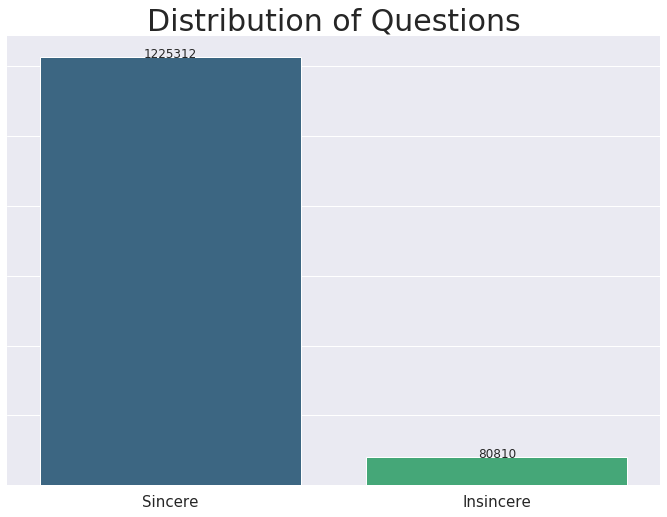

In [8]:
# Lets do some visualization
# Showing distribution of questions in training data
fig, ax = plt.subplots()
g = sns.countplot(train.target, palette='viridis')
g.set_xticklabels(['Sincere', 'Insincere'])
g.set_yticklabels([])

# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of Questions', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
fig.savefig('classes.png')
plt.show()

In [9]:
# Let's check percentage of each type of question in training data
num_insincere_questions = train.loc[train.target == 1]
num_sincere_questions = train.loc[train.target == 0]
percentage_insincere = len(num_insincere_questions) / train.shape[0] * 100
percentage_sincere = len(num_sincere_questions) / train.shape[0] * 100

print("Percentage of sincere questions: ", percentage_sincere)
print("Percentage of insincere questions: ", percentage_insincere)

Percentage of sincere questions:  93.81298224821265
Percentage of insincere questions:  6.187017751787352


In [10]:
# Now let's have a look at how insincere questions look like
import random

list_of_insincere_questions = random.sample(train.index[train.target == 1].tolist(), 10)
print(list_of_insincere_questions)
for i in list_of_insincere_questions:
    print(train.iloc[i, 1])

[120246, 77629, 1002402, 1130564, 764701, 411379, 1278437, 998390, 594465, 1086596]
Why are most serial killers homosexual?
Since the Holocaust was invented after WWII, does that mean its revisionist?
Why is it that inner-city blacks are doing so poorly in districts that have been run historically by Democrats?
How can Sikhs tolerate Hindus in Punjab? I would like to know the opinion of Sikhs.
Are you surprised that, as expected, the Novichok nerve agent wasn't proved to come from Russia? How many WMD cases do people need to understand that they are fed lies?
How was New Zealand able to conquer America so easily at the start of WW2?
Why do liberals feel they have the right to force what they feel is best on a vast majority of people who disagree with them, usually through punitive measures or outright violence?
Is it true that it's worse for a racist to kill one black person than for someone who isn't racist to kill a thousand black people inadvertently?
What can I do to avoid our futu

In [11]:
'''
Processing the whole training data takes a lot time. So,let's take a 
fraction of the dataset to speed up processing.
'''
train_new = train.sample(frac = 0.01)
print(train_new.shape)

(13061, 3)


In [12]:
# Tokenizing with spacy
nlp = en_core_web_sm.load()

train_new['tokens'] = [nlp(ques, # disabling parts of the language processing pipeline which we don't need here
                           disable = ['ner', # named entity recognition
                                       'tagger', # part-of-speech tagger
                                       'textcat', # document label categorizer
                                     ]) for ques in train_new.question_text]

# Printing the first five rows of the training data with their tokens
train_new.sample(5)

,qid,question_text,target,tokens
884291,ad40eb7a2d5e052c242f,"If Arvind Kejriwal might be the PM, then who w...",1,"(If, Arvind, Kejriwal, might, be, the, PM, ,, ..."
305422,3bd23d04e3f1ff0c9aeb,What are the challenges that Ben Bailey has fa...,0,"(What, are, the, challenges, that, Ben, Bailey..."
381558,4ac8869b2bd2deb5b229,Why there is still a qualifying percentage of ...,0,"(Why, there, is, still, a, qualifying, percent..."
376572,49d1e27dbb25a87bad35,How do I overcome my chronic dissatisfaction w...,0,"(How, do, I, overcome, my, chronic, dissatisfa..."
465766,5b3489835674980744bc,Why is Ace Chemicals not shutdown in the DC un...,0,"(Why, is, Ace, Chemicals, not, shutdown, in, t..."


In [13]:
# Number of toekns in each row
train_new['num_tokens'] = [len(token) for token in train_new.tokens]
train_new.sample(5)

,qid,question_text,target,tokens,num_tokens
965206,bd198f75d4bf8ff2cdbc,What do you think is the first thing any human...,0,"(What, do, you, think, is, the, first, thing, ...",14
37949,076aee6b6d3ee6280460,What is the mean of state-of-the-art in machin...,0,"(What, is, the, mean, of, state, -, of, -, the...",16
1104986,d88d775a826ccf9e4ede,What are the common uses of manganese?,0,"(What, are, the, common, uses, of, manganese, ?)",8
532591,68479e7414914a564bd5,How can I be a Buddhist while avoiding Western...,0,"(How, can, I, be, a, Buddhist, while, avoiding...",11
1090470,d5b2bf12d7ebdd22906e,Why I am afraid of losing my parents?,0,"(Why, I, am, afraid, of, losing, my, parents, ?)",9


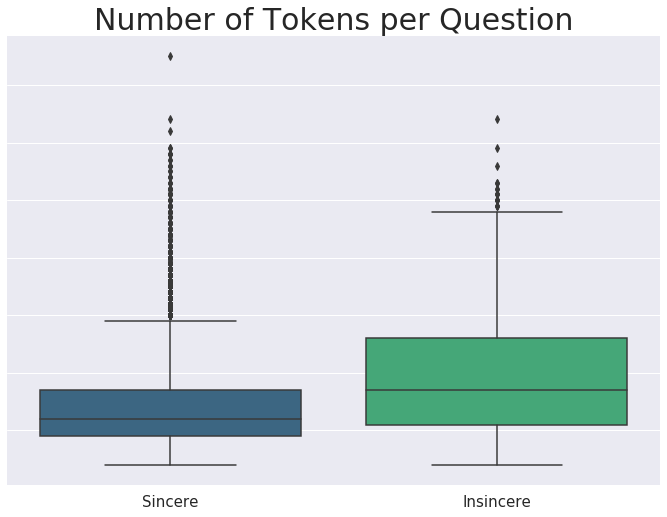

In [14]:
# using seaborns boxplot to visualize number of tokens per question
fig, ax = plt.subplots()
g = sns.boxplot(x=train_new.target, y=train_new.num_tokens, palette='viridis')
g.set_xticklabels(['Sincere', 'Insincere'])
g.set_yticklabels([])

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Number of Tokens per Question', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
fig.savefig('tokens.png')
plt.show()

In [15]:
# Now, getting number of sentences per question
print(list(train_new.iloc[0,3].sents))

sents = [list(x.sents) for x in train_new.tokens]
train_new['num_sents'] = [len(sent) for sent in sents]
train_new.sample(5)

[What is the iupac nane of (ch3), 3-c-o-c2h5?]


,qid,question_text,target,tokens,num_tokens,num_sents
303716,3b7a19297f2dbbbfe336,Is it strange to find neither gender physicall...,0,"(Is, it, strange, to, find, neither, gender, p...",10,1
305111,3bc3926a2cedc9dcef1f,Does everyone have a secret in their life?,0,"(Does, everyone, have, a, secret, in, their, l...",9,1
238111,2e9347e12c47b92840d1,How can I programmatically boot to the BIOS fr...,0,"(How, can, I, programmatically, boot, to, the,...",16,1
712450,8b774e1bf568a98254cc,Is it possible to be a voice actor and a hocke...,0,"(Is, it, possible, to, be, a, voice, actor, an...",28,1
1212279,ed9a2e751b44aa2a6283,How does someone get their family to love and ...,0,"(How, does, someone, get, their, family, to, l...",12,1


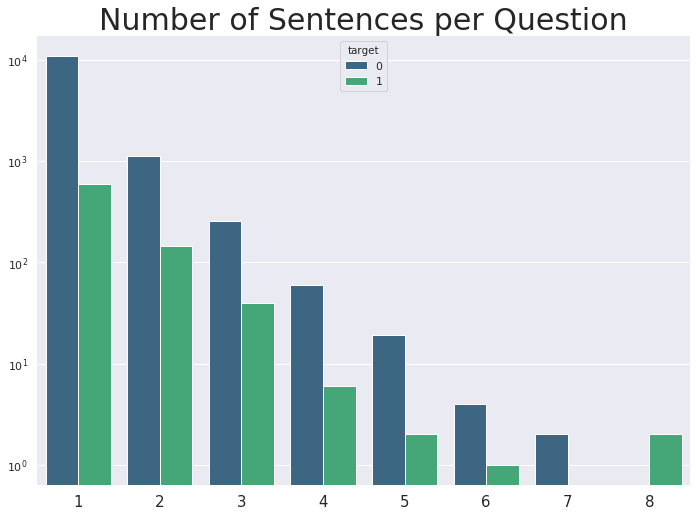

In [16]:
# plotting number of sentences per question
fig, ax = plt.subplots()
g = sns.countplot(train_new.num_sents, hue=train_new.target, palette='viridis')
g.set_yticklabels([])

# using log scale on y-axis so we can better see the questions with more sentences
ax.set(yscale='log')

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Number of Sentences per Question', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
fig.savefig('sentences.png')
plt.show()

In [17]:
# Finding most common words
# Defining function to cleanup text and remove personal pronouns, stopwords, and puncuation
nltk.download('stopwords')
punctuations = string.punctuation
stop_words = set(stopwords.words("english"))

def cleanup_text(docs):
    texts = []
    for doc in docs:
        doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
        doc = nlp(doc, disable=['ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stop_words and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# Grabbing all text associated with insincere questions
insincere_text = [text for text in train_new[train_new['target'] == 1]['question_text']]
insincere_clean = cleanup_text(insincere_text)
insincere_clean = ' '.join(insincere_clean).split()

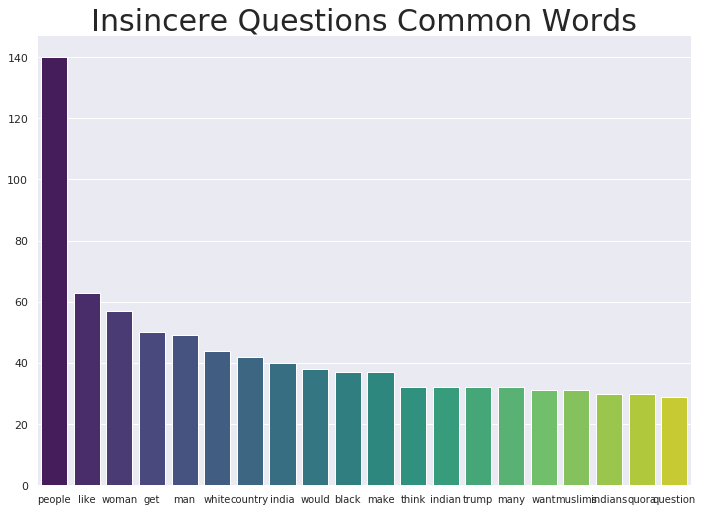

In [19]:
# Counting all unique words
insincere_counts = Counter(insincere_clean)
# Getting words and word counts
insincere_common_words = [word[0] for word in insincere_counts.most_common(20)]
insincere_common_counts = [word[1] for word in insincere_counts.most_common(20)]

# Plotting 20 most common words in insincere questions
sns.barplot(insincere_common_words, insincere_common_counts, palette='viridis')
sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Insincere Questions Common Words', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=10)
fig.savefig('insincere_words.png')
plt.show()

In [0]:
# Grabbing all text associated with sincere questions
sincere_text = [text for text in train_new[train_new['target'] == 0]['question_text']]
sincere_clean = cleanup_text(sincere_text)
sincere_clean = ' '.join(sincere_clean).split()

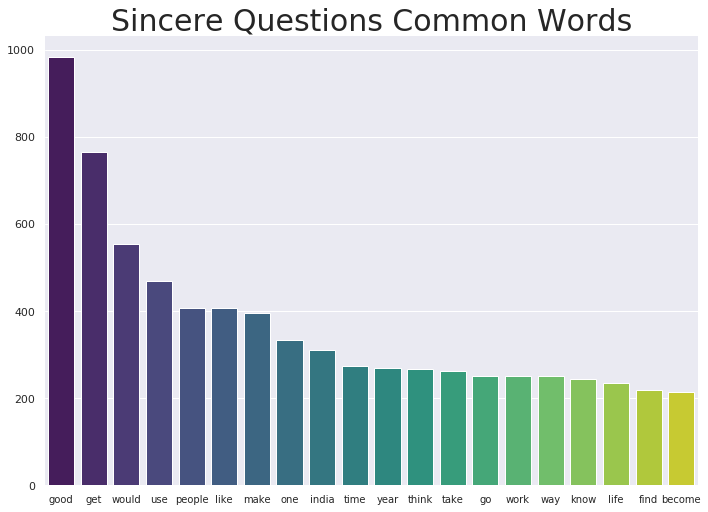

In [21]:
# Counting all unique words
sincere_counts = Counter(sincere_clean)
# Getting words and word counts
sincere_common_words = [word[0] for word in sincere_counts.most_common(20)]
sincere_common_counts = [word[1] for word in sincere_counts.most_common(20)]

# Plotting 20 most common words in sincere questions
sns.barplot(sincere_common_words, sincere_common_counts, palette='viridis')
sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Sincere Questions Common Words', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=10)
fig.savefig('sincere.png')
plt.show()

# Word Embedding 

The next few steps involve pre-processing:

1) Split the training dataset into train and val sample. Cross validation is a time consuming 
   process and so we will do simple train val split.

2) Fill up the missing values in the text column with 'na'

3) Tokenize the text column and convert them to vector sequences

4) Pad the sequence as needed - if the number of words in the text is 
   greater than 'max_len' trunacate them to 'max_len' or if the number of words 
   in the text is lesser than 'max_len' add zeros for remaining values.


In [101]:
'''
Processing the whole training data takes a lot time. So,let's take a 
fraction of the dataset to speed up processing.
'''
'''
train_process = train.sample(frac = 0.3)
print(train_process.shape)

test_df = test.sample(frac = 0.3)
print(test_df.shape)
'''

'\ntrain_process = train.sample(frac = 0.3)\nprint(train_process.shape)\n\ntest_df = test.sample(frac = 0.3)\nprint(test_df.shape)\n'

In [0]:
# Configuring the embedding matrix

embed_size = 300            #Each one-hot input vector is a 300 dimensional vector.
max_features = 120000        #Number of unique words to use (i.e num rows in embedding vector)
maxlen = 70               # max number of words in a question to use

In [0]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x

def split_text(x):
    x = wordninja.split(x)
    return '-'.join(x)

In [0]:
def load_and_prec():
    train_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/train.csv")
    test_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/test.csv")
    
    train_df["question_text"] = train_df["question_text"].str.lower()
    test_df["question_text"] = test_df["question_text"].str.lower()
    
    train_df["question_text"] = train_df["question_text"].apply(lambda x: clean_text(x))
    test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_text(x))
    
    print("Train shape : ",train_df.shape)
    print("Test shape : ",test_df.shape)
    
    ## split to train and val
    train_df, val_df = train_test_split(train_df, test_size=0.001, random_state=2018) 

     ## fill up the missing values
    train_X = train_df["question_text"].fillna("_##_").values
    val_X = val_df["question_text"].fillna("_##_").values
    test_X = test_df["question_text"].fillna("_##_").values

    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(train_X))
    train_X = tokenizer.texts_to_sequences(train_X)
    val_X = tokenizer.texts_to_sequences(val_X)
    test_X = tokenizer.texts_to_sequences(test_X)

    ## Pad the sentences 
    train_X = pad_sequences(train_X, maxlen=maxlen)
    val_X = pad_sequences(val_X, maxlen=maxlen)
    test_X = pad_sequences(test_X, maxlen=maxlen)

    ## Get the target values
    train_y = train_df['target'].values
    val_y = val_df['target'].values 
     

    #shuffling the data
    np.random.seed(2018)
    trn_idx = np.random.permutation(len(train_X))
    val_idx = np.random.permutation(len(val_X))

    train_X = train_X[trn_idx]
    val_X = val_X[val_idx]
    train_y = train_y[trn_idx]
    val_y = val_y[val_idx]    
    
    return train_X, val_X, test_X, train_y, val_y, tokenizer.word_index


In [0]:
def load_glove(word_index):
    EMBEDDING_FILE = '/content/drive/My Drive/Colab Notebooks/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8"))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 

In [0]:


#CNN Model

def model_cnn(embedding_matrix):
    filter_sizes = [1,2,3,5]
    num_filters = 36

    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Reshape((maxlen, embed_size, 1))(x)

    maxpool_pool = []
    for i in range(len(filter_sizes)):
        conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], embed_size),
                                     kernel_initializer='he_normal', activation='elu')(x)
        maxpool_pool.append(MaxPool2D(pool_size=(maxlen - filter_sizes[i] + 1, 1))(conv))

    z = Concatenate(axis=1)(maxpool_pool)   
    z = Flatten()(z)
    z = Dropout(0.1)(z)

    outp = Dense(1, activation="sigmoid")(z)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [0]:


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
        
        
    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [0]:
# Main model

def model_lstm_du(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(64, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [0]:
def train_pred(model, epochs=2):
    for e in range(epochs):
        model.fit(train_X, train_y, batch_size=512, epochs=1, validation_data=(val_X, val_y))
        pred_val_y = model.predict([val_X], batch_size=1024, verbose=0)
    pred_test_y = model.predict([test_X], batch_size=1024, verbose=0)
    return pred_val_y, pred_test_y

In [166]:
train_X, val_X, test_X, train_y, val_y, word_index = load_and_prec()
vocab = []
for w,k in word_index.items():
    vocab.append(w)
    if k >= max_features:
        break
embedding_matrix_1 = load_glove(word_index)

Train shape :  (1306122, 3)
Test shape :  (375806, 2)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [167]:
embedding_matrix = np.mean([embedding_matrix_1], axis = 0)
np.shape(embedding_matrix)

(120000, 300)

In [168]:
np.shape(embedding_matrix_1)

(120000, 300)

In [0]:
outputs = []

In [170]:
pred_val_y, pred_test_y = train_pred(model_cnn(embedding_matrix_1), epochs = 3) # GloVe only
outputs.append([pred_val_y, pred_test_y, '2d CNN GloVe'])

Train on 1304815 samples, validate on 1307 samples
Epoch 1/1
1304815/1304815 [==============================] - 107s 82us/step - loss: 0.1117 - acc: 0.9559 - val_loss: 0.0931 - val_acc: 0.9587
Train on 1304815 samples, validate on 1307 samples
Epoch 1/1
1304815/1304815 [==============================] - 105s 80us/step - loss: 0.0922 - acc: 0.9630 - val_loss: 0.0917 - val_acc: 0.9625
Train on 1304815 samples, validate on 1307 samples
Epoch 1/1
1304815/1304815 [==============================] - 105s 80us/step - loss: 0.0770 - acc: 0.9696 - val_loss: 0.0964 - val_acc: 0.9610


In [171]:
pred_val_y, pred_test_y = train_pred(model_lstm_du(embedding_matrix_1), epochs = 3)
outputs.append([pred_val_y, pred_test_y, 'BiLSTM w/ MaxPooling'])

Train on 1304815 samples, validate on 1307 samples
Epoch 1/1
1304815/1304815 [==============================] - 90s 69us/step - loss: 0.1093 - acc: 0.9568 - val_loss: 0.0928 - val_acc: 0.9579
Train on 1304815 samples, validate on 1307 samples
Epoch 1/1
1304815/1304815 [==============================] - 88s 68us/step - loss: 0.0893 - acc: 0.9641 - val_loss: 0.0950 - val_acc: 0.9587
Train on 1304815 samples, validate on 1307 samples
Epoch 1/1
1304815/1304815 [==============================] - 89s 68us/step - loss: 0.0747 - acc: 0.9699 - val_loss: 0.0964 - val_acc: 0.9640


In [0]:
# pred_test_y = np.sum([outputs[i][1] * weights[i] for i in range(len(outputs))], axis = 0)
coefs = [0.11611663,0.14885248]
# pred_test_y = np.mean([outputs[i][1] for i in range(len(outputs))], axis = 0)
pred_test_y = np.sum([outputs[i][1]*coefs[i] for i in range(len(coefs))], axis = 0)   

pred_test_y = (pred_test_y > 0.34).astype(int)
test_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/test.csv", usecols=["qid"])
out_df = pd.DataFrame({"qid":test_df["qid"].values})
out_df['prediction'] = pred_test_y
out_df.to_csv("/content/drive/My Drive/Colab Notebooks/submission.csv", index=False)

In [0]:
pred = pd.read_csv('/content/drive/My Drive/Colab Notebooks/submissions.csv')
predicted_vals = pred['target']

In [0]:
actual_vals = val_df['target']

In [233]:
print(predicted_vals.shape)
print(actual_vals.shape)

(1307,)
(1307,)


In [234]:
# F1 score
from sklearn.metrics import f1_score
f1_score(actual_vals, predicted_vals, average= 'macro')

0.6808957832796085